# Analysis of the LacI titration data and comparison with theory

This exercise was generated from a Jupyter notebook. You can download the notebook [here](laci_titration.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# Show images in greyscale by default
plt.rcParams['image.cmap'] = 'Greys_r'

# For extracting pathnames
import glob

# For reading files
import skimage.io

# For extracting features of objects in images
import skimage.measure

# For applying filters on images
import skimage.filters

# Step 1: Phase image -> Labeled mask

### 1.1 Background subtraction

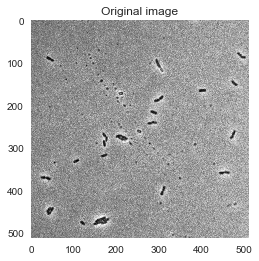

In [28]:
# Read an example phase contrast image
im = skimage.io.imread('data/lacI_titration/O2_R124_phase_pos_02.tif')

# Show the image
plt.imshow(im)
plt.grid('off')
plt.title('Original image')

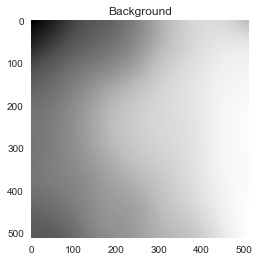

In [29]:
# Normalize it
im_float = (im - np.min(im))/(np.max(im)-np.min(im))

# Find the background
gauss_radius = 50
im_bg = skimage.filters.gaussian(im_float, sigma=gauss_radius)

# Show the background
plt.imshow(im_bg)
plt.grid('off')
plt.title('Background')

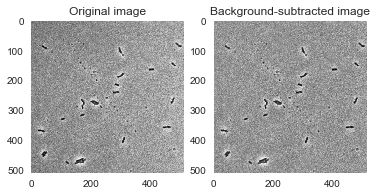

In [4]:
# Perform a background subtraction
im_gauss = im_float - im_bg

# Show the background-subtracted image
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_float)
ax[0].set_title('Original image')
ax[0].grid('off')

ax[1].imshow(im_gauss)
ax[1].set_title('Background-subtracted image')
ax[1].grid('off')

### 1.2 Thresholding

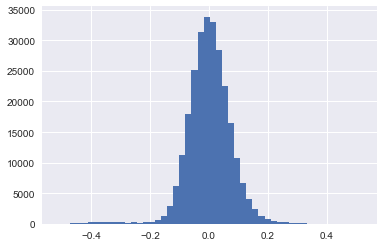

In [5]:
# Plot a histogram of pixel values
_ = plt.hist(im_gauss.flatten(), bins = 50)

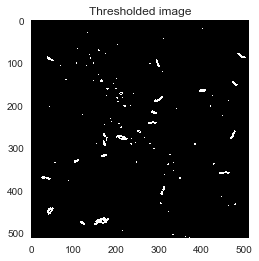

In [6]:
# Choose a threshold
threshold = -0.2

# Thresholded image
im_thresh = im_gauss < threshold

# Show the thresholded image
plt.imshow(im_thresh)
plt.grid('off')
plt.title('Thresholded image')

### 1.3 Remove the small objects and create a mask

In [7]:
# Label the objects in the binary image
im_label, n_objects = skimage.measure.label(im_thresh, return_num = True)

# Print the number of objects found
print(str(n_objects) + ' objects are found in the binary image')

179 objects are found in the binary image


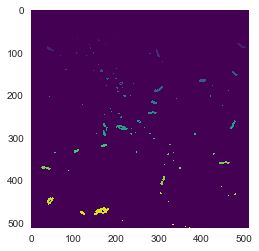

In [8]:
# Show the labeled image in a colored scale
plt.imshow(im_label, cmap = plt.cm.viridis)
plt.grid('off')

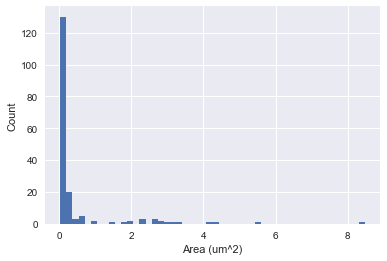

In [9]:
# Length calibration in um/pixel
pixel_size = 0.16

# List to store area values in um^2
areas = []

# Obtain the areas of all labeled objects
props = skimage.measure.regionprops(im_label)

for prop in props:
    areas.append(prop.area * pixel_size**2)
    
# Take a look at the distribution
_ = plt.hist(areas, bins = 50)
plt.xlabel('Area (um^2)')
plt.ylabel('Count')

# Area bounds
area_low = 1
area_high = 10

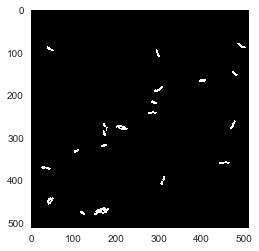

In [10]:
# Create a 2d array of zeros
im_mask = np.zeros_like(im_thresh)

for prop in props:
    area = prop.area * pixel_size**2
    if (area > area_low) and (area < area_high):
        im_mask = im_mask + (im_label == prop.label)
        
        # Uncomment to see how the objects are added sequentially
#         plt.figure()
#         plt.imshow(im_mask)
#         plt.grid('off')
plt.imshow(im_mask)
plt.grid('off')

In [11]:
# Label the remaining objects
im_mask_label, n_objects_mask = skimage.measure.label(im_mask, return_num = True)

# Print the number of object after size filtering
print(str(n_objects_mask) + ' objects remain after filtering')

19 objects remain after filtering


### 1.4 Turn the procedure into a function

In [12]:
def create_mask (phase_image, gauss_radius = 50, threshold = -0.2, \
                 pixel_size = 0.16, area_low = 1, area_high = 6):
    
    # Normalize
    im_float = (phase_image - np.min(phase_image))/(np.max(phase_image)-np.min(phase_image))
    
    # Find the background
    im_bg = skimage.filters.gaussian(im_float, gauss_radius)
    
    # Subtract the background
    im_gauss = im_float - im_bg
    
    # Threshold the image
    im_thresh = im_gauss < threshold
    
    # Label the image
    im_label = skimage.measure.label(im_thresh)
    
    # Obtain the features of the objects
    props = skimage.measure.regionprops(im_label)
    
    # Remove small objects
    im_mask = np.zeros_like(im_label)
    for prop in props:
        area = prop.area * pixel_size**2
        if (area > area_low) and (area < area_high):
            im_mask = im_mask + (im_label == prop.label)
            
    # Label the mask
    im_mask_label = skimage.measure.label(im_mask)
    
    # Return the labeled mask
    return im_mask_label

# Step 2: YFP image + mask -> Intensity values

### 2.1 Develop the pipeline

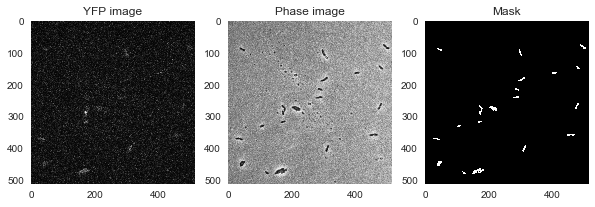

In [13]:
# Read the matching YFP image
im_yfp = skimage.io.imread('data/lacI_titration/O2_R124_yfp_pos_02.tif')

# Show them next to each other
fig, ax = plt.subplots(1,3, figsize=[10,3])
ax[0].imshow(im_yfp)
ax[0].grid('off')
ax[0].set_title('YFP image')

ax[1].imshow(im)
ax[1].grid('off')
ax[1].set_title('Phase image')

ax[2].imshow(im_mask)
ax[2].grid('off')
ax[2].set_title('Mask')

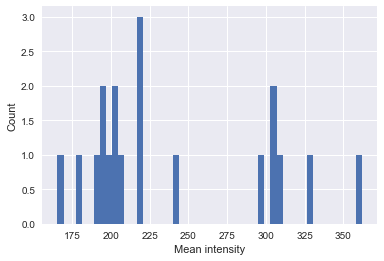

In [14]:
# List to store the object intensity values
intensities = []

# Obtain the features of objects in the YFP channel
props = skimage.measure.regionprops(im_mask_label, intensity_image=im_yfp)

# Add the YFP intensity values
for prop in props:
    intensities.append(prop.mean_intensity)
    
# Histogram of intensity values
_ = plt.hist(intensities, bins = 50)
plt.xlabel('Mean intensity')
plt.ylabel('Count')

### 2.2 Turn the pipeline into a function

In [15]:
def find_intensities (im_yfp, im_mask_label):

    # List to store the object intensity values
    intensities = []

    # Obtain the features of objects in the YFP channel
    props = skimage.measure.regionprops(im_mask_label, intensity_image=im_yfp)

    # Add the YFP intensity values
    for prop in props:
        intensities.append(prop.mean_intensity)
    
    return intensities

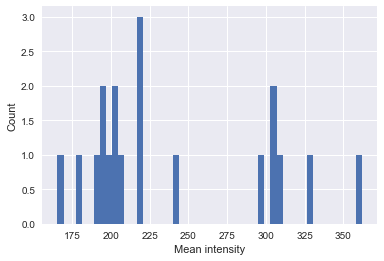

In [16]:
# Check to see if it's working
intensities_fn = find_intensities(im_yfp, im_mask_label)

# Make a histogram
_ = plt.hist(intensities_fn, bins = 50)
plt.xlabel('Mean intensity')
plt.ylabel('Count')

# Step 3: Intensity values for all images of a given strain

### 3.1 Develop the pipeline

In [17]:
# Strain information
operator = 'O2'
repressor = 'R124'

# Array to store intensity values from all the strains
intensities_all = []

# Filename structure
file_structure_phase = 'data/lacI_titration/' + operator + '_' + repressor + '_' + 'phase*'
file_structure_yfp = 'data/lacI_titration/' + operator + '_' + repressor + '_' + 'yfp*'

# Name of all images for a given strain
phase_names = glob.glob(file_structure_phase)
yfp_names = glob.glob(file_structure_yfp)

# Number of positions
n_positions = len(phase_names)

for i in range(n_positions):
    im_phase = skimage.io.imread(phase_names[i])
    im_yfp = skimage.io.imread(yfp_names[i])
    
    im_mask_label = create_mask(im_phase)
    intensities = find_intensities(im_yfp, im_mask_label)
    
    for intensity in intensities:
        intensities_all.append(intensity)

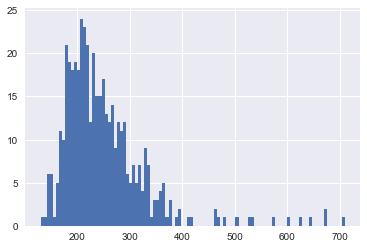

In [18]:
# Show all the intensity values
_ = plt.hist(intensities_all, bins = 100)

### 3.2 Turn it into a function

In [19]:
def find_intensities_all (operator, repressor):
    # Array to store intensity values from all the strains
    intensities_all = []

    # Filename structure
    file_structure_phase = 'data/lacI_titration/' + operator + '_' + repressor + '_' + 'phase*'
    file_structure_yfp = 'data/lacI_titration/' + operator + '_' + repressor + '_' + 'yfp*'

    # Name of all images for a given strain
    phase_names = glob.glob(file_structure_phase)
    yfp_names = glob.glob(file_structure_yfp)

    # Number of positions
    n_positions = len(phase_names)

    for i in range(n_positions):
        im_phase = skimage.io.imread(phase_names[i])
        im_yfp = skimage.io.imread(yfp_names[i])

        im_mask_label = create_mask(im_phase)
        intensities = find_intensities(im_yfp, im_mask_label)

        for intensity in intensities:
            intensities_all.append(intensity)
            
    return intensities_all

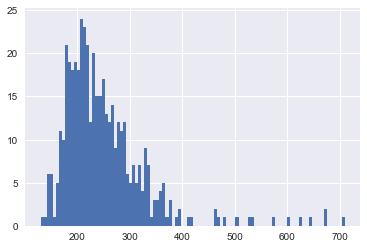

In [20]:
# Check that it's working
operator = 'O2'
repressor = 'R124'

intensities_all_fn = find_intensities_all(operator, repressor)

_ = plt.hist(intensities_all_fn, bins = 100)

# Step 4: Obtain the fold-change for a given strain

### 4.1 Develop the pipeline

In [21]:
# Strain information
operator = 'O2'
repressor = 'R124'

# Mean intensities for 'auto', 'delta' and 'Rxxx'
intensity_mean_auto = np.mean(find_intensities_all(operator, 'auto'))
intensity_mean_delta = np.mean(find_intensities_all(operator, 'delta'))
intensity_mean_R = np.mean(find_intensities_all(operator, repressor))

# Calculate the fold-change
fold_change = (intensity_mean_R - intensity_mean_auto)/(intensity_mean_delta - intensity_mean_auto)

# Show the fold-change
print('Fold-change = ' + str(fold_change))

Fold-change = 0.0265641357735


### 4.2 Turn it into a function

In [22]:
def find_fold_change (operator, repressor):
    # Mean intensities for 'auto', 'delta' and 'Rxxx'
    intensity_mean_auto = np.mean(find_intensities_all(operator, 'auto'))
    intensity_mean_delta = np.mean(find_intensities_all(operator, 'delta'))
    intensity_mean_R = np.mean(find_intensities_all(operator, repressor))

    # Calculate the fold-change
    fold_change = (intensity_mean_R - intensity_mean_auto)/(intensity_mean_delta - intensity_mean_auto)
    
    return fold_change

In [23]:
# Check that it's working correctly
fold_change_fn = find_fold_change(operator, repressor)

# Display the fold-change
print('Fold-change using the function = ' + str(fold_change_fn))

Fold-change using the function = 0.0265641357735


# Step 5: Analyze the entire dataset

In [24]:
# Names of strain parameters
operators = ['O1', 'O2', 'O3']
repressors = ['R22', 'R60', 'R124', 'R260', 'R1220', 'R1740']
repressor_counts = [22, 60, 124, 260, 1220, 1740]

# Numbers different strain parameters
n_operators = len(operators)
n_repressors = len(repressors)

# Fold-change matrix
fold_change_values = np.zeros([n_operators, n_repressors])

for i in range(n_operators):
    for j in range(n_repressors):
        
        # Choose the ith operator
        operator = operators[i]
        
        # Choose the jth repressor
        repressor = repressors[j]
        
        # Find the fold-change
        fold_change_values[i,j] = find_fold_change(operator, repressor)

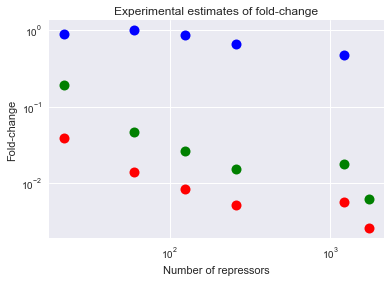

In [25]:
# Assign a color to each operator
colors = ['r', 'g', 'b']

# Plot fold-change as a function of the repressor count
for i in range(n_operators):
    plt.loglog(repressor_counts, fold_change_values[i,:], '.', markersize = 20, color = colors[i])
    
plt.xlabel('Number of repressors')
plt.ylabel('Fold-change')
plt.title('Experimental estimates of fold-change')

# Step 6: Obtain theory curves

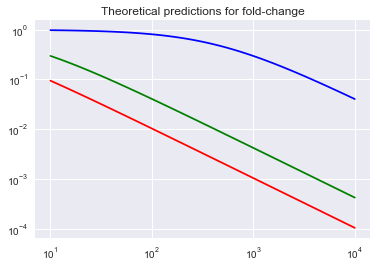

In [32]:
# Number of non-specific sites
nNS = 4.6E6

# Repressor binding energies in kT units
dE = [-15.3, -13.9, -9.3]

# Range of repressor copy numbers
R_range = np.logspace(1, 4, 100)

# Find and plot the theoretical predictions
for i in range(n_operators):
    fold_change = 1/(1 + R_range/nNS * np.exp(-dE[i]))
    plt.loglog(R_range, fold_change, color = colors[i])

plt.title('Theoretical predictions for fold-change')

# Step 7: Compare theory and experiment

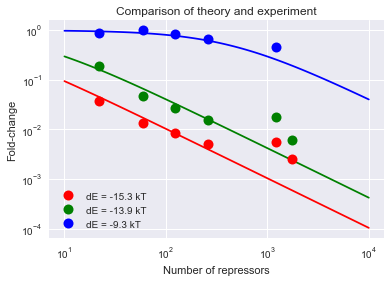

In [33]:
# Overlay experiment and theory
for i in range(n_operators):
    fold_change = 1/(1 + R_range/nNS * np.exp(-dE[i]))
    plt.loglog(R_range, fold_change, color = colors[i])

for i in range(n_operators):
    plt.loglog(repressor_counts, fold_change_values[i,:], '.', markersize = 20, \
               color = colors[i], label = 'dE = ' + str(dE[i]) + ' kT')
    
plt.xlabel('Number of repressors')
plt.ylabel('Fold-change')
plt.title('Comparison of theory and experiment')
plt.legend()